In [27]:
import pyphi
import scipy.io
import numpy as np
from scipy.fft import fft
from scipy.signal import butter, filtfilt, welch
import matplotlib.pyplot as plt

In [7]:
mat = scipy.io.loadmat("/content/sub_0010-mr_0015-ecr_echo1_EEG_pp.mat")
print(mat["EEG"]["data"][0][0].shape)
EEG = mat["EEG"]["data"][0][0]

(32, 367499)


## Identifying sequence structure and characteristics 

In [17]:
def main_frequency(eeg_data, sampling_rate):
    """
    Calculate the main frequency of the given EEG data using Fast Fourier Transform (FFT).

    :param eeg_data: 2D numpy array of shape (num_channels, num_samples)
    :param sampling_rate: Sampling rate of the EEG data in Hz
    :return: A list containing the main frequency for each channel
    """
    num_channels, num_samples = eeg_data.shape
    main_frequencies = []

    for channel in range(num_channels):
        # Calculate the FFT
        eeg_fft = fft(eeg_data[channel])

        # Calculate the frequencies corresponding to the FFT values
        freqs = np.fft.fftfreq(num_samples, 1 / sampling_rate)

        # Find the index of the maximum magnitude in the positive frequency range
        positive_freqs = freqs[:num_samples // 2]
        eeg_fft_magnitude = np.abs(eeg_fft[:num_samples // 2])
        max_magnitude_index = np.argmax(eeg_fft_magnitude)

        # Get the main frequency
        main_freq = positive_freqs[max_magnitude_index]
        main_frequencies.append(main_freq)

    return main_frequencies

def plot_frequency_map(eeg_data, eeg_fft, sampling_rate):
    """
    Plot the frequency map of the given EEG data using its FFT on a semi-log scale.

    :param eeg_data: 2D numpy array of shape (num_channels, num_samples)
    :param eeg_fft: 2D numpy array of shape (num_channels, num_samples) containing the FFT of the EEG data
    :param sampling_rate: Sampling rate of the EEG data in Hz
    """
    num_channels, num_samples = eeg_data.shape

    # Calculate the frequencies corresponding to the FFT values
    freqs = np.fft.fftfreq(num_samples, 1 / sampling_rate)
    positive_freqs = freqs[:num_samples // 2]

    for channel in range(num_channels):
        plt.figure()
        plt.title(f"Frequency Spectrum for Channel {channel + 1}")

        # Plot the magnitude of the FFT for the positive frequency range
        eeg_fft_magnitude = np.abs(eeg_fft[channel, :num_samples // 2])
        plt.xlim(0, 100)  # Updated frequency range to 0-100 Hz
        plt.semilogy(positive_freqs, eeg_fft_magnitude)  # Use semilogy instead of plot for semi-log scale
        
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude (log)")
        plt.grid()

    plt.show()

def bandpass_filter(eeg_data, lowcut, highcut, sampling_rate, order=4):
    """
    Apply a Butterworth band-pass filter to the given EEG data.

    :param eeg_data: 2D numpy array of shape (num_channels, num_samples)
    :param lowcut: Lower frequency limit of the band-pass filter in Hz
    :param highcut: Upper frequency limit of the band-pass filter in Hz
    :param sampling_rate: Sampling rate of the EEG data in Hz
    :param order: Order of the Butterworth filter (default is 4)
    :return: 2D numpy array of filtered EEG data with the same shape as input eeg_data
    """
    def butter_bandpass(lowcut, highcut, fs, order=4):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a

    num_channels, num_samples = eeg_data.shape
    filtered_eeg_data = np.zeros((num_channels, num_samples))

    b, a = butter_bandpass(lowcut, highcut, sampling_rate, order)

    for channel in range(num_channels):
        filtered_eeg_data[channel] = filtfilt(b, a, eeg_data[channel])

    return filtered_eeg_data

def plot_alpha_band(eeg_data, filtered_eeg_data, sampling_rate):
    """
    Plot the 8-12 Hz filtered EEG data for three channels as a function of time.

    :param eeg_data: 2D numpy array of shape (num_channels, num_samples) containing the original EEG data
    :param filtered_eeg_data: 2D numpy array of shape (num_channels, num_samples) containing the filtered EEG data
    :param sampling_rate: Sampling rate of the EEG data in Hz
    """
    num_channels, num_samples = eeg_data.shape
    time = np.arange(num_samples) / sampling_rate

    # Plot the first three channels
    for channel in range(min(3, num_channels)):
        plt.figure()
        plt.title(f"8-12 Hz Filtered EEG for Channel {channel + 1}")
        plt.plot(time, filtered_eeg_data[channel], label="Filtered")
        plt.plot(time, eeg_data[channel], label="Original", alpha=0.5)
        
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid()

    plt.show()

  


# For calculating Φ value

In [13]:
def calculate_phi(EEG):
    def preprocess_data(EEG):
        mean = np.mean(EEG, axis=1)
        std = np.std(EEG, axis=1)
        z_score = (EEG - mean[:, np.newaxis]) / std[:, np.newaxis]
        z_score_binary = np.where(z_score > 0, 1, 0)
        return np.transpose(z_score_binary)

    def tmp_generator(n):
        results = np.zeros((2**n, n))
        for i in range(2**n):
            for j in range(n):
                results[i, j] = i >> j & 1
        return results

    def count_and_frequency_of_state_transitions(data, states):
        transition_matrix = np.zeros((len(states), len(states)))
        for i in range(len(data) - 1):
            current_state = data[i]
            next_state = data[i + 1]
            current_state_index = np.where((states == current_state).all(axis=1))[0][0]
            next_state_index = np.where((states == next_state).all(axis=1))[0][0]
            transition_matrix[current_state_index, next_state_index] += 1
        frequency = transition_matrix / np.sum(transition_matrix, axis=1, keepdims=True)
        average = 0
        frequency[np.isnan(frequency)] = average
        return transition_matrix, frequency

    EEG_first_3_channels = EEG
    z_score_binary = preprocess_data(EEG_first_3_channels)
    states = tmp_generator(3)

    transition_matrix, frequency = count_and_frequency_of_state_transitions(z_score_binary, states)
    sbn_tpm = pyphi.convert.state_by_state2state_by_node(frequency)
    sbs_tpm = pyphi.convert.state_by_node2state_by_state(sbn_tpm)

    network = pyphi.Network(sbs_tpm)
    phi_values = []

    for state in states:
        subsystem = pyphi.Subsystem(network, [int(x) for x in state])
        phi_value = pyphi.compute.phi(subsystem)
        phi_values.append(phi_value)
    
    return phi_values, max(phi_values)

def split_and_calculate_phi(EEG_first_3_channels, sampling_rate, time):

    # Calculate the number of samples in a <time> second window
    window_size = time * sampling_rate
    num_windows = len(EEG_first_3_channels[0]) // window_size

    # Initialize an empty list to store the phi values for each window
    phi_values = []
    # Iterate through the windows and calculate phi for each window
    for i in range(num_windows):
        start = i * window_size
        end = (i + 1) * window_size

        # Extract the 10-second window for each channel
        window = [channel[start:end] for channel in EEG_first_3_channels]

        # Calculate phi for the current window and append it to the list
        phi_list , phi = calculate_phi(window)
        phi_values.append(phi)
        

    return phi_values



## For calculating main frequency over each time window

In [14]:
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.fft import fft
import matplotlib.pyplot as plt

def process_eeg_channel_main_frequency(eeg_data, channel_index, lowcut, highcut, sampling_rate, time):
    """
    Process the specified EEG channel: apply a band-pass filter, slice into 10-second time windows,
    and calculate the main frequency for each time window.

    :param eeg_data: 2D numpy array of shape (num_channels, num_samples)
    :param channel_index: Index of the EEG channel to process
    :param lowcut: Lower frequency limit of the band-pass filter in Hz
    :param highcut: Upper frequency limit of the band-pass filter in Hz
    :param sampling_rate: Sampling rate of the EEG data in Hz
    :return: A list containing the main frequency for each <time> time window
    """
    def butter_bandpass(lowcut, highcut, fs, order=4):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a

    def main_frequency(eeg_data, sampling_rate):
        num_samples = eeg_data.shape[0]

        # Calculate the FFT
        eeg_fft = fft(eeg_data)

        # Calculate the frequencies corresponding to the FFT values
        freqs = np.fft.fftfreq(num_samples, 1 / sampling_rate)

        # Find the index of the maximum magnitude in the positive frequency range
        positive_freqs = freqs[:num_samples // 2]
        eeg_fft_magnitude = np.abs(eeg_fft[:num_samples // 2])
        max_magnitude_index = np.argmax(eeg_fft_magnitude)

        # Get the main frequency
        main_freq = positive_freqs[max_magnitude_index]

        return main_freq
    # Apply the band-pass filter to the specified channel
    channel_data = eeg_data[channel_index]
    b, a = butter_bandpass(lowcut, highcut, sampling_rate)
    filtered_channel_data = filtfilt(b, a, channel_data) 
    # Calculate the main frequency for each 10-second time window
    window_size = time * sampling_rate
    num_windows = filtered_channel_data.shape[0] // window_size
    main_frequencies = []

    for i in range(num_windows):
        window_data = filtered_channel_data[i * window_size:(i + 1) * window_size]
        main_freq = main_frequency(window_data, sampling_rate)
        main_frequencies.append(main_freq)

    return main_frequencies

## For calculating band power for each time window 

In [15]:
def process_eeg_channel_power(eeg_data, channel_index, lowcut, highcut, sampling_rate, time):
    """
    Process the specified EEG channel: apply a band-pass filter, slice into <time>-second time windows,
    and calculate the band power for each time window.

    :param eeg_data: 2D numpy array of shape (num_channels, num_samples)
    :param channel_index: Index of the EEG channel to process
    :param lowcut: Lower frequency limit of the band-pass filter in Hz
    :param highcut: Upper frequency limit of the band-pass filter in Hz
    :param sampling_rate: Sampling rate of the EEG data in Hz
    :return: A list containing the band power for each 10-second time window
    """
    def butter_bandpass(lowcut, highcut, fs, order=4):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a

    def calculate_band_power(eeg_data, sampling_rate, lowcut, highcut):
        freqs, psd = welch(eeg_data, sampling_rate, nperseg=sampling_rate)
        band_power = np.trapz(psd[(freqs >= lowcut) & (freqs <= highcut)], dx=np.diff(freqs)[0])
        return band_power

    # Apply the band-pass filter to the specified channel
    channel_data = eeg_data[channel_index]
    b, a = butter_bandpass(lowcut, highcut, sampling_rate)
    filtered_channel_data = filtfilt(b, a, channel_data)

    # Calculate the band power for each 10-second time window
    window_size = time * sampling_rate
    num_windows = filtered_channel_data.shape[0] // window_size
    band_powers = []

    for i in range(num_windows):
        window_data = filtered_channel_data[i * window_size:(i + 1) * window_size]
        band_power = calculate_band_power(window_data, sampling_rate, lowcut, highcut)
        band_powers.append(band_power)

    return band_powers

# Combining functions together: Ploting 

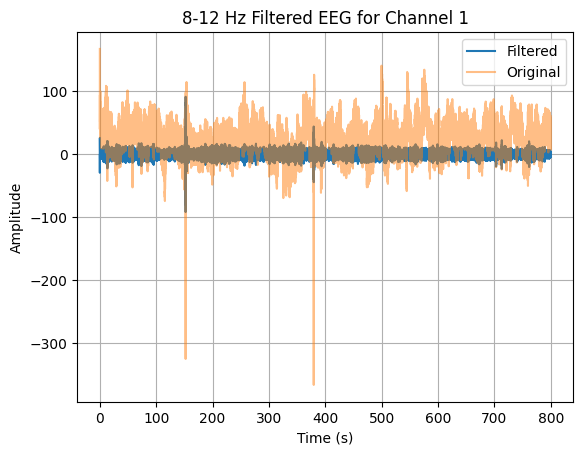

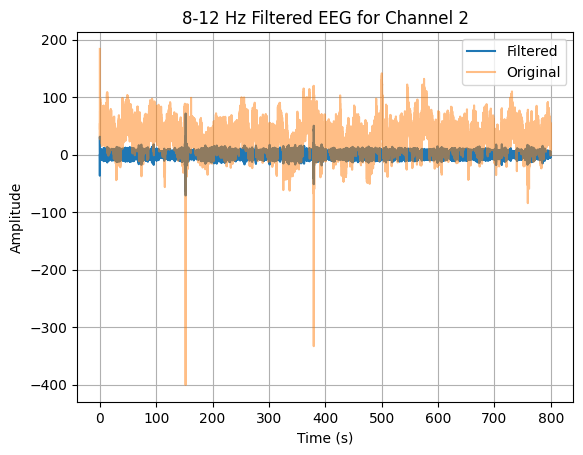

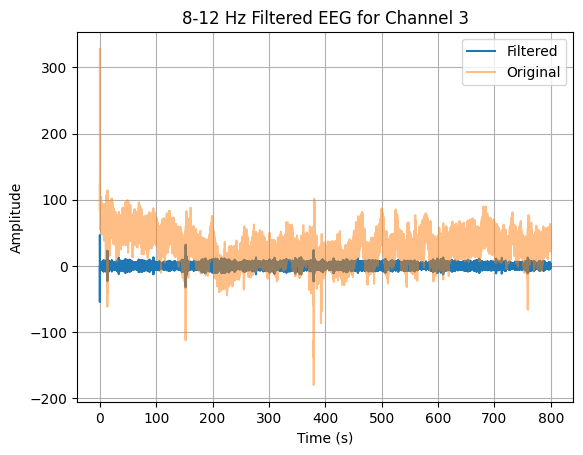

In [21]:
# example
EEG_first_3_channels = EEG[:3, :200000]
sampling_rate = 250
lowcut,highcut = 8, 12 # Lower frequency limit in Hz (e.g., 8 Hz for alpha band), Upper frequency limit in Hz (e.g., 12 Hz for alpha band)
filtered_eeg_data = bandpass_filter(EEG_first_3_channels, lowcut, highcut, sampling_rate)
plot_alpha_band(EEG_first_3_channels, filtered_eeg_data, sampling_rate)

Main frequencies for each channel: [9.295, 9.295, 9.295]


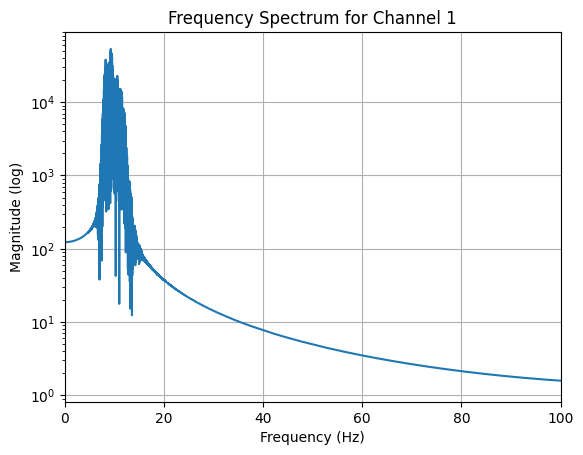

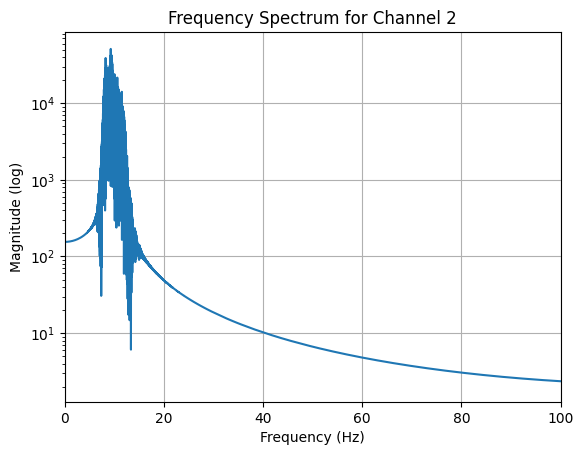

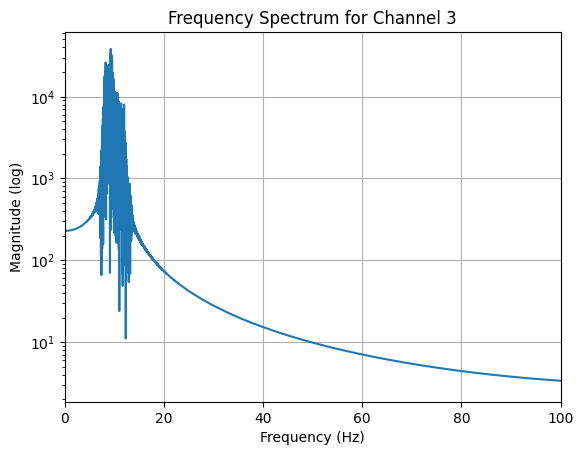

In [22]:
main_frequencies = main_frequency(filtered_eeg_data, sampling_rate)
print("Main frequencies for each channel:", main_frequencies)
eeg_fft = np.fft.fft(filtered_eeg_data, axis=1)  # Calculate the FFT of the EEG data
plot_frequency_map(filtered_eeg_data, eeg_fft, sampling_rate)

In [44]:
def plot_phi_with_main_frequency(main_frequencies_1, main_frequencies_2, main_frequencies_3):
  x_values = range(len(main_frequencies_1))
  plt.rcParams.update({'font.size': 20})
  # Create the figure and first axis
  fig, ax1 = plt.subplots()
  fig.set_size_inches(20, 6)
  # Plot the main frequencies on the left y-axis with reduced opacity (alpha)
  ax1.plot(x_values, main_frequencies_1, label="Main Frequencies 1", linestyle="-", marker="o", alpha=0.3)
  ax1.plot(x_values, main_frequencies_2, label="Main Frequencies 2", linestyle="-", marker="o", alpha=0.3)
  ax1.plot(x_values, main_frequencies_3, label="Main Frequencies 3", linestyle="-", marker="o", alpha=0.3)
  ax1.plot(x_values, np.mean(np.array([main_frequencies_1, main_frequencies_2, main_frequencies_3]), axis=0) , label="Average Main Frequency", linestyle="-", marker="o", alpha=1)
  # Set the labels for the left y-axis
  ax1.set_ylabel("Main Frequencies")
  ax1.legend(loc="upper left")

  # Create a second y-axis sharing the same x-axis
  ax2 = ax1.twinx()

  # Plot the phi_values on the right y-axis with a different linestyle, marker, and color
  ax2.plot(x_values, phi_values, label="Phi Values", linestyle="--", marker="x", color="purple")

  # Set the labels for the right y-axis
  ax2.set_ylabel("Phi Values")

  ax2.legend(loc="upper right")

  # Set the x-axis label
  plt.xlabel("Time in mins")

  # Set the title
  plt.title("Main Frequencies and Phi Values")

  plt.show()

In [45]:
def plot_phi_with_band_power(band_powers_1,band_powers_2,band_powers_3):
  x_values = range(len(band_powers_1))
  plt.rcParams.update({'font.size': 20})
  # Create the figure and first axis
  fig, ax1 = plt.subplots()
  fig.set_size_inches(20, 6)
  # Plot the main frequencies on the left y-axis with reduced opacity (alpha)
  ax1.plot(x_values, band_powers_1, label="Band Power 1", linestyle="-", marker="o", alpha=0.3)
  ax1.plot(x_values, band_powers_2, label="Band Power 2", linestyle="-", marker="o", alpha=0.3)
  ax1.plot(x_values, band_powers_3, label="Band Power 3", linestyle="-", marker="o", alpha=0.3)
  ax1.plot(x_values, np.mean(np.array([band_powers_1, band_powers_2, band_powers_3]), axis=0) , label="Average Band Power", linestyle="-", marker="o", alpha=1)
  # Set the labels for the left y-axis
  ax1.set_ylabel("Band Power")
  ax1.legend(loc="upper left")

  # Create a second y-axis sharing the same x-axis
  ax2 = ax1.twinx()

  # Plot the phi_values on the right y-axis with a different linestyle, marker, and color
  ax2.plot(x_values, phi_values, label="Phi Values", linestyle="--", marker="x", color="purple")

  # Set the labels for the right y-axis
  ax2.set_ylabel("Phi Values")
  ax2.legend(loc="upper right")

  # Set the x-axis label
  plt.xlabel("Index")

  # Set the title
  plt.title("Band Power and Phi Values")

  # Show the plot
  plt.savefig('ex.png')
  plt.show()

## Alpha Band
- Window 60s

In [46]:
window_time = 60
sampling_rate = 250
lowcut, highcut  = 8, 12

EEG_first_3_channels = EEG[:3, :15000*20]  # Given data 
filtered_eeg_data = bandpass_filter(EEG_first_3_channels, lowcut, highcut, sampling_rate)
phi_values = split_and_calculate_phi(filtered_eeg_data, sampling_rate, window_time)
print("Phi values for each 60-second time window:", phi_values)

channel_index = 0
main_frequencies_1 = process_eeg_channel_main_frequency(EEG_first_3_channels, channel_index, lowcut, highcut, sampling_rate,window_time)
print("Main frequencies of channel 1 for each time window:", main_frequencies_1)

channel_index = 1
main_frequencies_2 = process_eeg_channel_main_frequency(EEG_first_3_channels, channel_index, lowcut, highcut, sampling_rate,window_time)
print("Main frequencies of channel 2 for each time window:", main_frequencies_2)

channel_index = 2
main_frequencies_3 = process_eeg_channel_main_frequency(EEG_first_3_channels, channel_index, lowcut, highcut, sampling_rate,window_time)
print("Main frequencies of channel 3 for each time window:", main_frequencies_3)

print("Phi values for each time window:", phi_values)



Phi values for each 60-second time window: [0.166794, 0.151808, 0.072813, 0.185426, 0.169019, 0.117881, 0.223437, 0.127557, 0.157334, 0.156421, 0.180967, 0.130556, 0.203534, 0.118952, 0.191414, 0.172583, 0.153323, 0.11147, 0.129428, 0.161064]
Main frequencies of channel 1 for each time window: [8.3, 9.583333333333334, 9.433333333333334, 9.233333333333333, 9.1, 9.316666666666666, 9.3, 9.566666666666666, 8.516666666666666, 9.55, 9.566666666666666, 9.35, 9.483333333333333, 9.233333333333333, 9.533333333333333, 9.4, 9.566666666666666, 9.4, 8.616666666666667, 9.483333333333333]
Main frequencies of channel 2 for each time window: [9.533333333333333, 9.583333333333334, 9.433333333333334, 9.233333333333333, 9.1, 9.316666666666666, 9.3, 9.566666666666666, 8.516666666666666, 9.55, 9.566666666666666, 9.083333333333334, 9.483333333333333, 9.233333333333333, 9.533333333333333, 9.4, 9.15, 9.4, 9.55, 9.533333333333333]
Main frequencies of channel 3 for each time window: [9.216666666666667, 9.21666666

In [47]:
channel_index = 0

band_powers_1 = process_eeg_channel_power(EEG_first_3_channels, channel_index, lowcut, highcut, sampling_rate,window_time)

channel_index = 1
band_powers_2 = process_eeg_channel_power(EEG_first_3_channels, channel_index, lowcut, highcut, sampling_rate,window_time)

channel_index = 2
band_powers_3 = process_eeg_channel_power(EEG_first_3_channels, channel_index, lowcut, highcut, sampling_rate,window_time)

Main Frequency

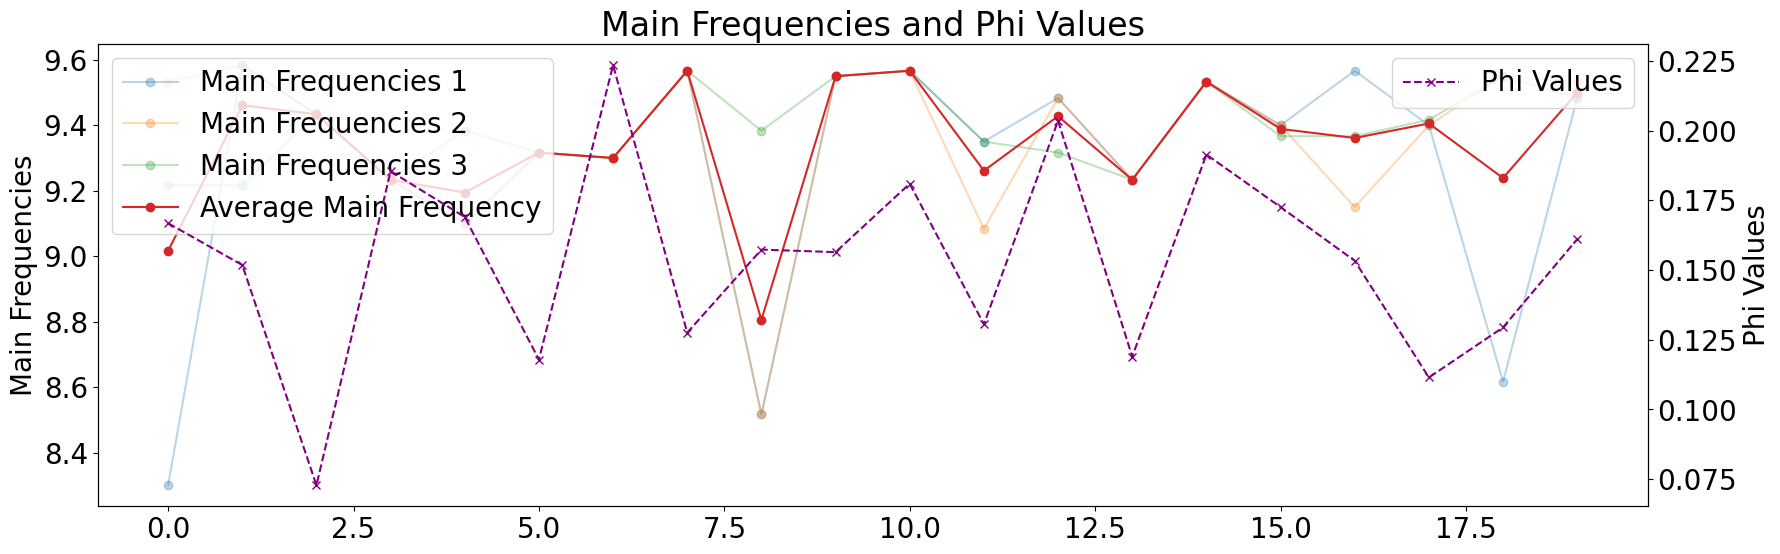

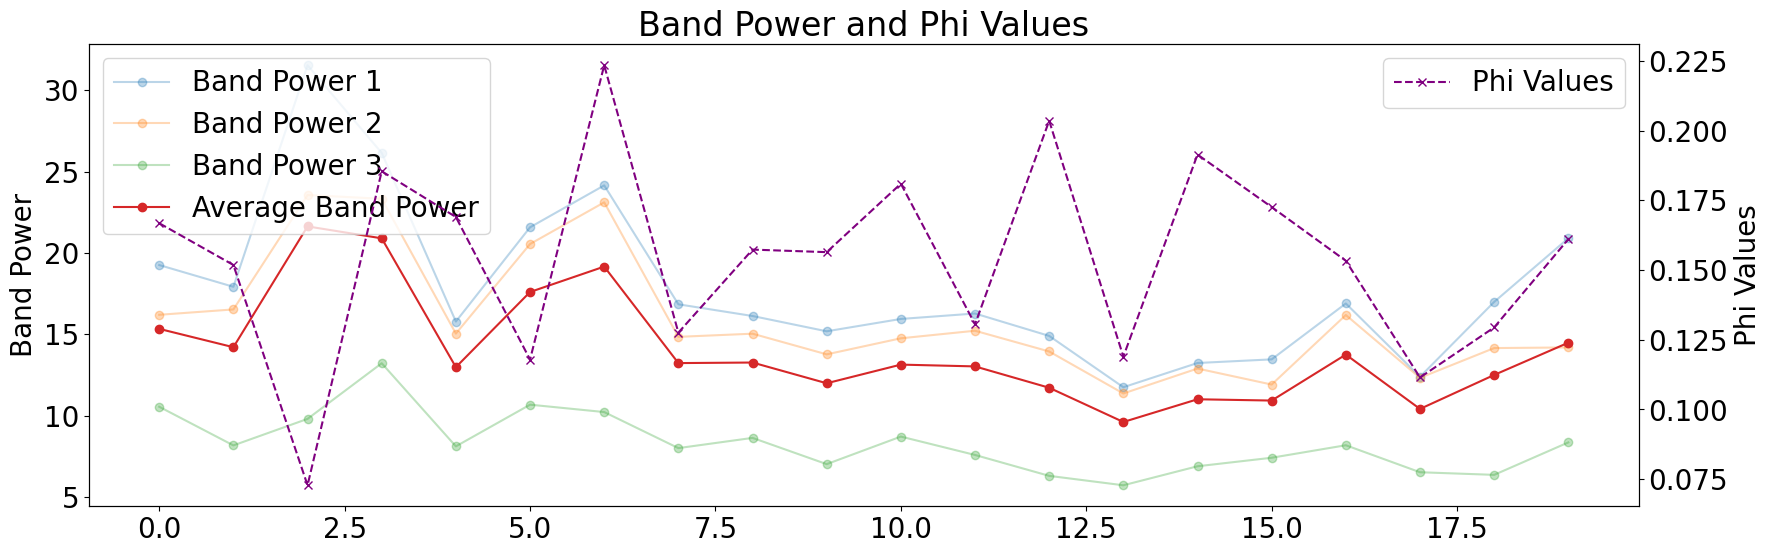

In [48]:
plot_phi_with_main_frequency(main_frequencies_1, main_frequencies_2, main_frequencies_3)
plot_phi_with_band_power(band_powers_1,band_powers_2,band_powers_3)

## Beta Band

In [49]:
window_time = 60
sampling_rate = 250
lowcut, highcut  = 12.5, 30

EEG_first_3_channels = EEG[:3, :15000*20]  # Given data 
filtered_eeg_data = bandpass_filter(EEG_first_3_channels, lowcut, highcut, sampling_rate)
phi_values = split_and_calculate_phi(filtered_eeg_data, sampling_rate, window_time)
print("Phi values for each 60-second time window:", phi_values)

channel_index = 0
main_frequencies_1 = process_eeg_channel_main_frequency(EEG_first_3_channels, channel_index, lowcut, highcut, sampling_rate,window_time)
print("Main frequencies of channel 1 for each time window:", main_frequencies_1)

channel_index = 1
main_frequencies_2 = process_eeg_channel_main_frequency(EEG_first_3_channels, channel_index, lowcut, highcut, sampling_rate,window_time)
print("Main frequencies of channel 2 for each time window:", main_frequencies_2)

channel_index = 2
main_frequencies_3 = process_eeg_channel_main_frequency(EEG_first_3_channels, channel_index, lowcut, highcut, sampling_rate,window_time)
print("Main frequencies of channel 3 for each time window:", main_frequencies_3)

print("Phi values for each time window:", phi_values)

channel_index = 0
band_powers_1 = process_eeg_channel_power(EEG_first_3_channels, channel_index, lowcut, highcut, sampling_rate,window_time)

channel_index = 1
band_powers_2 = process_eeg_channel_power(EEG_first_3_channels, channel_index, lowcut, highcut, sampling_rate,window_time)

channel_index = 2
band_powers_3 = process_eeg_channel_power(EEG_first_3_channels, channel_index, lowcut, highcut, sampling_rate,window_time)



Phi values for each 60-second time window: [0.14813, 0.153671, 0.132516, 0.138677, 0.158555, 0.156049, 0.162221, 0.17301, 0.148924, 0.15462, 0.129785, 0.155809, 0.131591, 0.13103, 0.110591, 0.131065, 0.104259, 0.130093, 0.09544, 0.106395]
Main frequencies of channel 1 for each time window: [15.183333333333334, 25.183333333333334, 29.983333333333334, 27.5, 25.183333333333334, 14.383333333333333, 25.2, 25.183333333333334, 29.983333333333334, 25.183333333333334, 25.183333333333334, 25.183333333333334, 25.2, 25.183333333333334, 25.183333333333334, 26.083333333333332, 25.2, 14.983333333333333, 25.2, 26.083333333333332]
Main frequencies of channel 2 for each time window: [14.15, 25.183333333333334, 29.983333333333334, 15.083333333333334, 25.183333333333334, 14.383333333333333, 16.6, 25.183333333333334, 29.983333333333334, 25.966666666666665, 27.583333333333332, 26.066666666666666, 22.8, 25.183333333333334, 15.083333333333334, 15.233333333333333, 25.2, 15.233333333333333, 25.2, 25.2]
Main fre

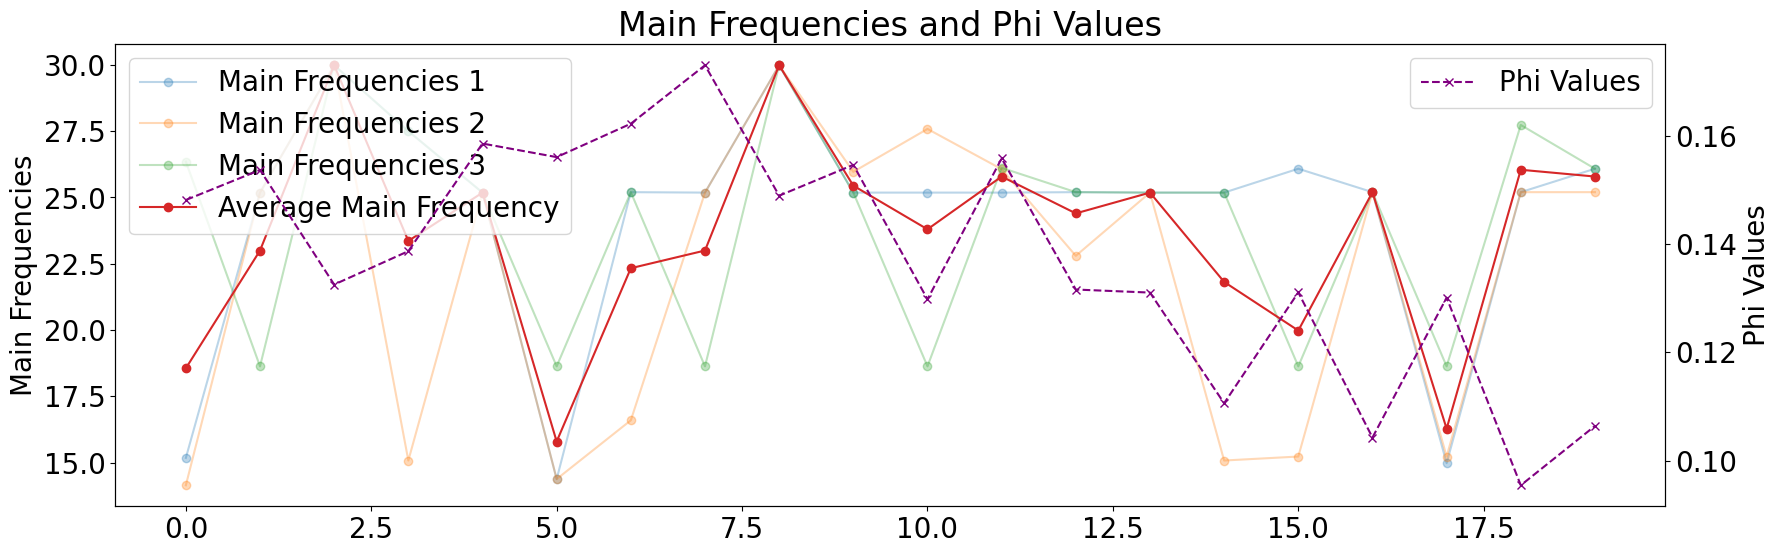

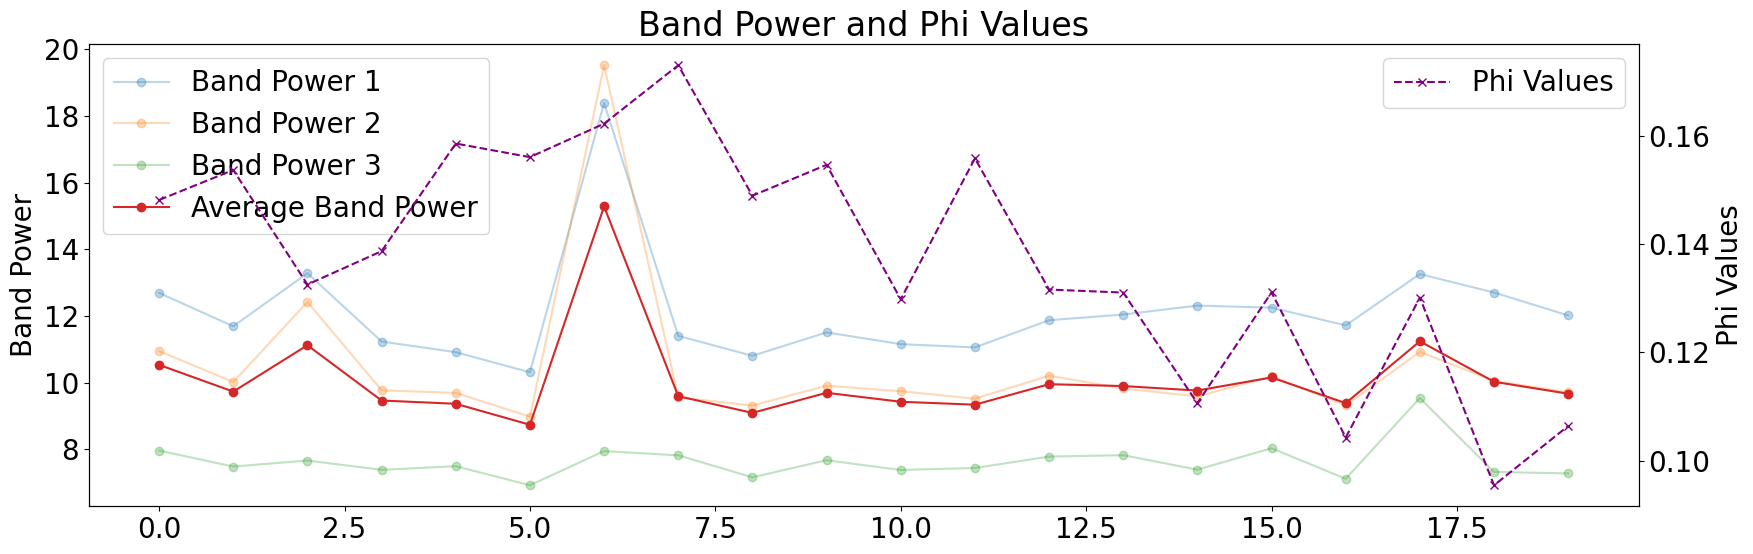

In [50]:
plot_phi_with_main_frequency(main_frequencies_1, main_frequencies_2, main_frequencies_3)
plot_phi_with_band_power(band_powers_1,band_powers_2,band_powers_3)

## Delta Band

In [51]:
window_time = 60
sampling_rate = 250
lowcut, highcut  = 1, 4

EEG_first_3_channels = EEG[:3, :15000*20]  # Given data 
filtered_eeg_data = bandpass_filter(EEG_first_3_channels, lowcut, highcut, sampling_rate)
phi_values = split_and_calculate_phi(filtered_eeg_data, sampling_rate, window_time)
print("Phi values for each 60-second time window:", phi_values)

channel_index = 0
main_frequencies_1 = process_eeg_channel_main_frequency(EEG_first_3_channels, channel_index, lowcut, highcut, sampling_rate,window_time)
print("Main frequencies of channel 1 for each time window:", main_frequencies_1)

channel_index = 1
main_frequencies_2 = process_eeg_channel_main_frequency(EEG_first_3_channels, channel_index, lowcut, highcut, sampling_rate,window_time)
print("Main frequencies of channel 2 for each time window:", main_frequencies_2)

channel_index = 2
main_frequencies_3 = process_eeg_channel_main_frequency(EEG_first_3_channels, channel_index, lowcut, highcut, sampling_rate,window_time)
print("Main frequencies of channel 3 for each time window:", main_frequencies_3)

print("Phi values for each time window:", phi_values)

channel_index = 0
band_powers_1 = process_eeg_channel_power(EEG_first_3_channels, channel_index, lowcut, highcut, sampling_rate,window_time)

channel_index = 1
band_powers_2 = process_eeg_channel_power(EEG_first_3_channels, channel_index, lowcut, highcut, sampling_rate,window_time)

channel_index = 2
band_powers_3 = process_eeg_channel_power(EEG_first_3_channels, channel_index, lowcut, highcut, sampling_rate,window_time)


Phi values for each 60-second time window: [0.099974, 0.13297, 0.063904, 0.106255, 0.099408, 0.059024, 0.080942, 0.071941, 0.115081, 0.104241, 0.078532, 0.083974, 0.092716, 0.07992, 0.101384, 0.103034, 0.084041, 0.101349, 0.102624, 0.08144]
Main frequencies of channel 1 for each time window: [1.6666666666666667, 1.2333333333333334, 1.5166666666666666, 1.3, 1.5833333333333333, 1.15, 1.1833333333333333, 1.4333333333333333, 1.3666666666666667, 1.2166666666666666, 1.5166666666666666, 2.25, 1.35, 1.3833333333333333, 2.533333333333333, 1.1666666666666667, 1.2333333333333334, 1.2, 1.1666666666666667, 1.7333333333333334]
Main frequencies of channel 2 for each time window: [1.1666666666666667, 1.2333333333333334, 1.4333333333333333, 1.5, 2.0833333333333335, 1.15, 1.45, 1.1, 1.5333333333333332, 1.2166666666666666, 1.15, 1.5166666666666666, 1.9833333333333334, 1.3833333333333333, 2.533333333333333, 1.1666666666666667, 1.4166666666666667, 1.4333333333333333, 1.1666666666666667, 1.45]
Main frequenc

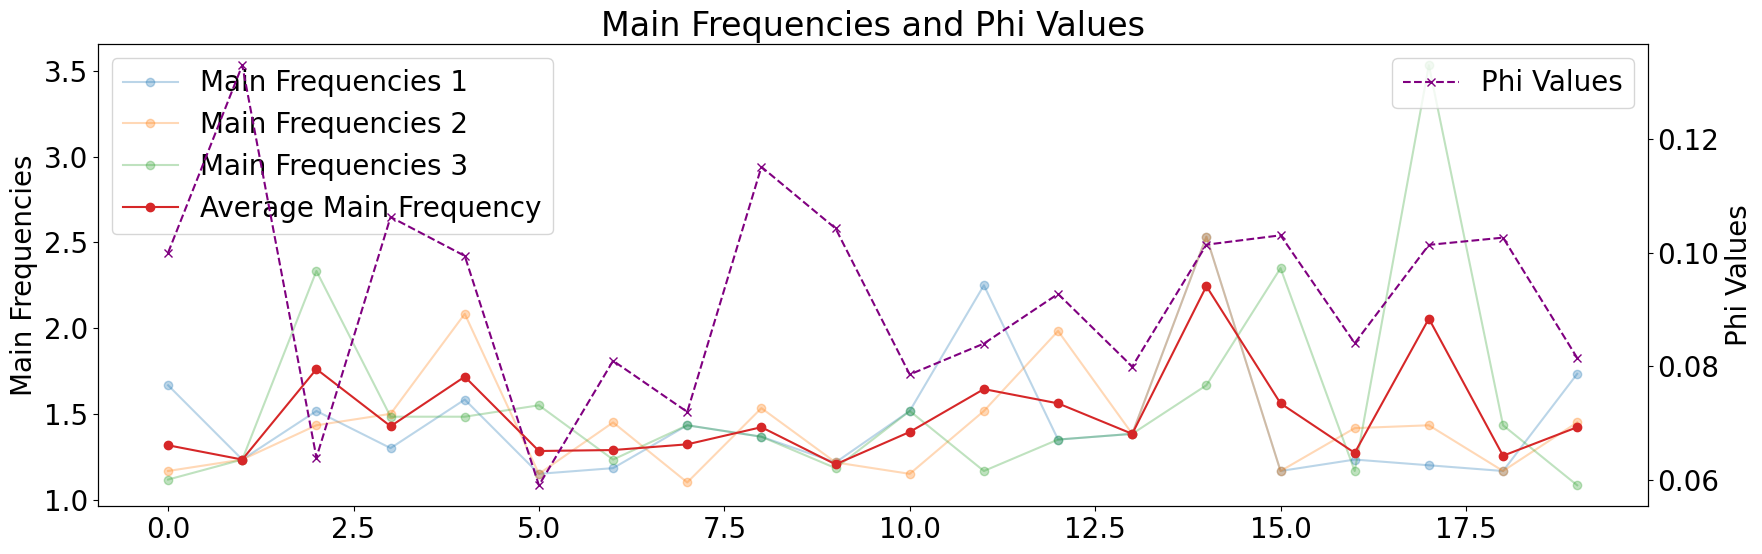

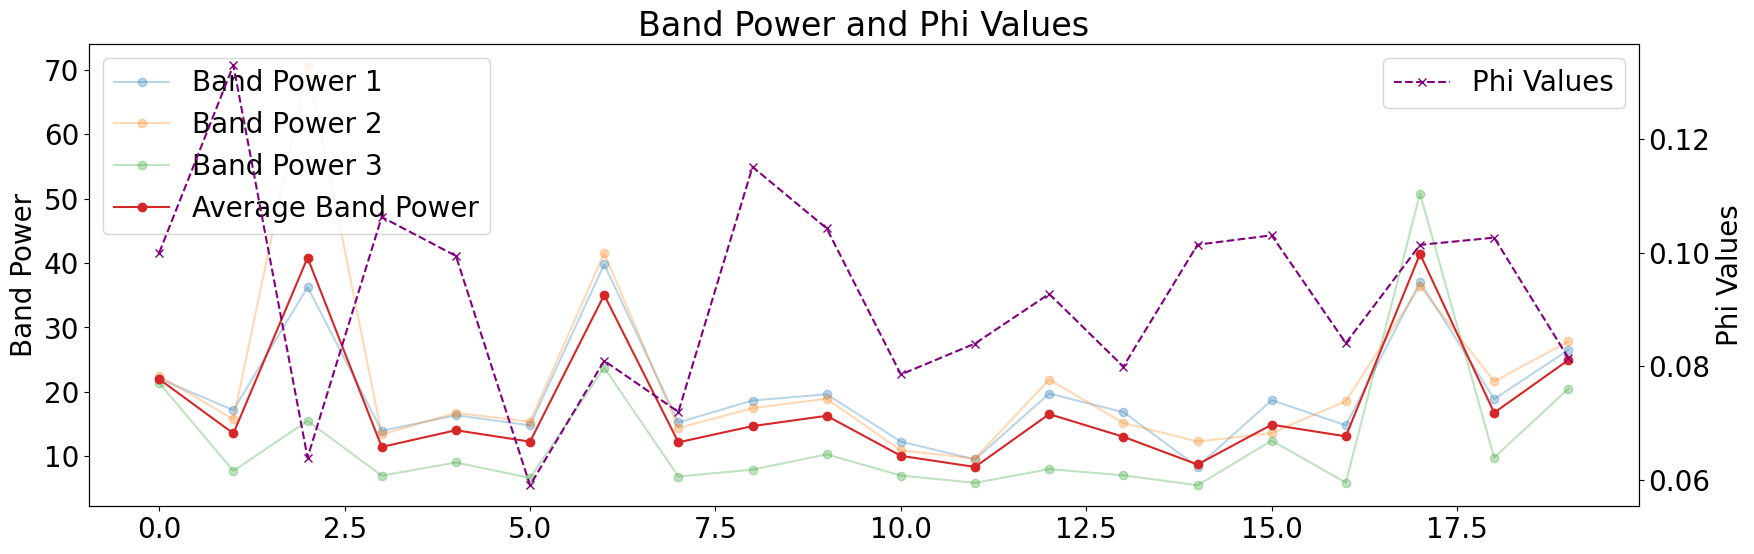

In [52]:
plot_phi_with_main_frequency(main_frequencies_1, main_frequencies_2, main_frequencies_3)
plot_phi_with_band_power(band_powers_1,band_powers_2,band_powers_3)

## Theta Band

In [53]:
window_time = 60
sampling_rate = 250
lowcut, highcut  = 4, 7

EEG_first_3_channels = EEG[:3, :15000*20]  # Given data 
filtered_eeg_data = bandpass_filter(EEG_first_3_channels, lowcut, highcut, sampling_rate)
phi_values = split_and_calculate_phi(filtered_eeg_data, sampling_rate, window_time)
print("Phi values for each 60-second time window:", phi_values)

channel_index = 0
main_frequencies_1 = process_eeg_channel_main_frequency(EEG_first_3_channels, channel_index, lowcut, highcut, sampling_rate,window_time)
print("Main frequencies of channel 1 for each time window:", main_frequencies_1)

channel_index = 1
main_frequencies_2 = process_eeg_channel_main_frequency(EEG_first_3_channels, channel_index, lowcut, highcut, sampling_rate,window_time)
print("Main frequencies of channel 2 for each time window:", main_frequencies_2)

channel_index = 2
main_frequencies_3 = process_eeg_channel_main_frequency(EEG_first_3_channels, channel_index, lowcut, highcut, sampling_rate,window_time)
print("Main frequencies of channel 3 for each time window:", main_frequencies_3)

print("Phi values for each time window:", phi_values)

channel_index = 0
band_powers_1 = process_eeg_channel_power(EEG_first_3_channels, channel_index, lowcut, highcut, sampling_rate,window_time)

channel_index = 1
band_powers_2 = process_eeg_channel_power(EEG_first_3_channels, channel_index, lowcut, highcut, sampling_rate,window_time)

channel_index = 2
band_powers_3 = process_eeg_channel_power(EEG_first_3_channels, channel_index, lowcut, highcut, sampling_rate,window_time)


Phi values for each 60-second time window: [0.106784, 0.176887, 0.199175, 0.168492, 0.164907, 0.147079, 0.185965, 0.234117, 0.143148, 0.212347, 0.142287, 0.173425, 0.174773, 0.19537, 0.183829, 0.162134, 0.141655, 0.311743, 0.100755, 0.136321]
Main frequencies of channel 1 for each time window: [5.25, 5.283333333333333, 5.233333333333333, 5.166666666666667, 5.516666666666667, 4.533333333333333, 4.933333333333334, 6.2, 5.716666666666667, 6.333333333333333, 5.3, 5.3, 5.866666666666666, 5.25, 5.45, 4.333333333333333, 5.966666666666667, 4.7, 5.333333333333333, 6.616666666666666]
Main frequencies of channel 2 for each time window: [6.533333333333333, 6.833333333333333, 5.35, 5.983333333333333, 5.266666666666667, 6.616666666666666, 4.7, 6.2, 6.266666666666667, 4.75, 6.6499999999999995, 6.55, 5.666666666666667, 6.1, 6.2, 6.45, 6.466666666666667, 6.05, 6.466666666666667, 6.45]
Main frequencies of channel 3 for each time window: [5.583333333333333, 4.333333333333333, 5.483333333333333, 5.9833333

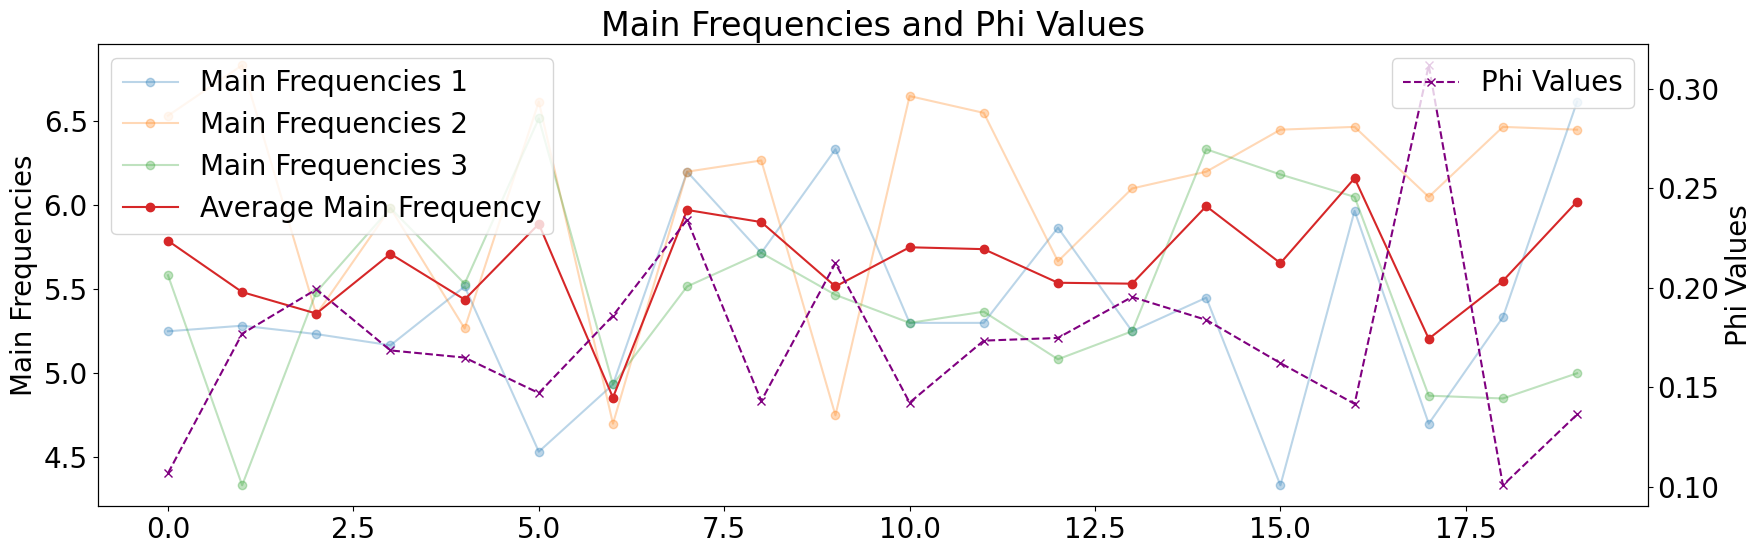

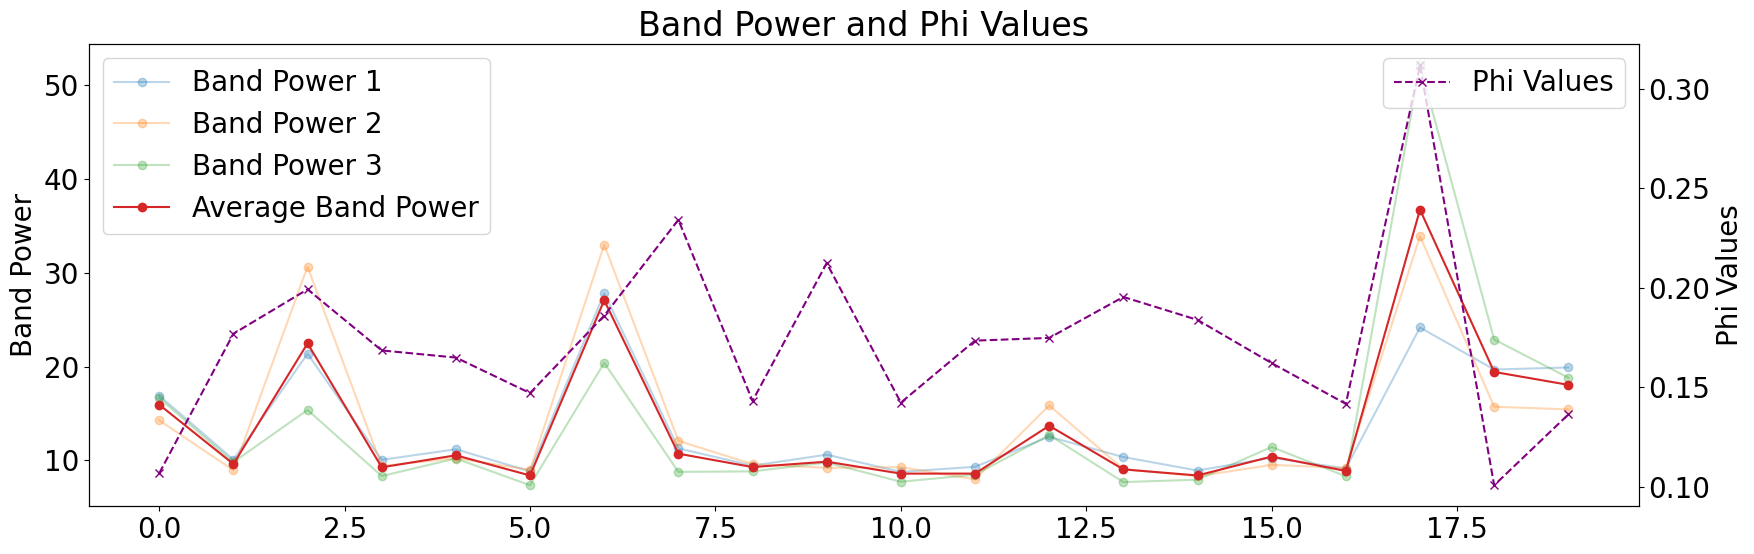

In [54]:
plot_phi_with_main_frequency(main_frequencies_1, main_frequencies_2, main_frequencies_3)
plot_phi_with_band_power(band_powers_1,band_powers_2,band_powers_3)

# Delta/Beta Power Spectrum

In [71]:
def plot_deltaoverbeta_power(delta_data, beta_data, deltaoverbeta_data, sampling_rate):

    num_channels, num_samples = deltaoverbeta_data.shape
    time = np.arange(num_samples) / sampling_rate

    # Plot the first three channels
    for channel in range(min(3, num_channels)):
        plt.figure()
        plt.title(f"Filtered EEG for Channel {channel + 1}")
        plt.plot(time, deltaoverbeta_data[channel], label="Delta/Beta")
        plt.plot(time, delta_data[channel], label="Delta", alpha=0.3)
        plt.plot(time, beta_data[channel], label="Beta", alpha=0.3)
        
        # plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid()

    plt.show()
  
def bin_data(data, bin_size):
  binned_data = np.zeros((data.shape[0], data.shape[1] // bin_size))
  for i in range(0, data.shape[1], bin_size):
      binned_data[:, i // bin_size] = np.mean(data[:, i:i+bin_size], axis=1)
  return binned_data

In [61]:
window_time = 60
sampling_rate = 250
EEG_first_3_channels = EEG[:3, :15000*20]  # Given data 
filtered_eeg_data_beta = bandpass_filter(EEG_first_3_channels, 12.5, 30, sampling_rate)
filtered_eeg_data_delta = bandpass_filter(EEG_first_3_channels, 1, 4, sampling_rate)

deltaoverbeta = filtered_eeg_data_delta / filtered_eeg_data_beta
deltaoverbeta.shape

(3, 300000)

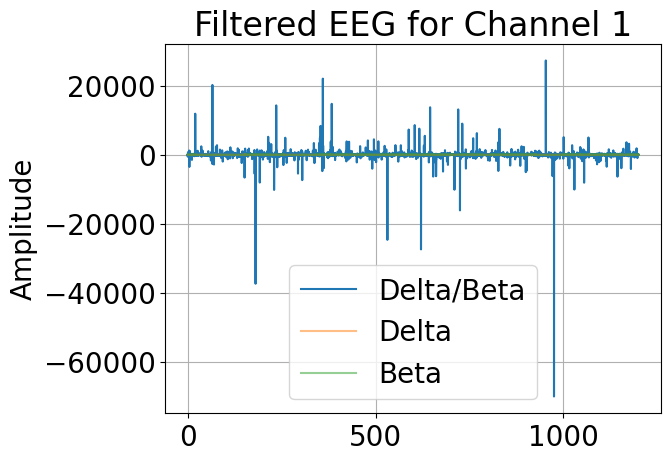

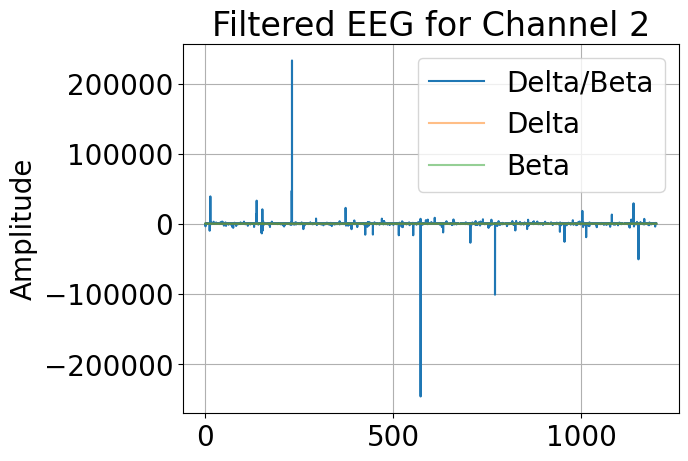

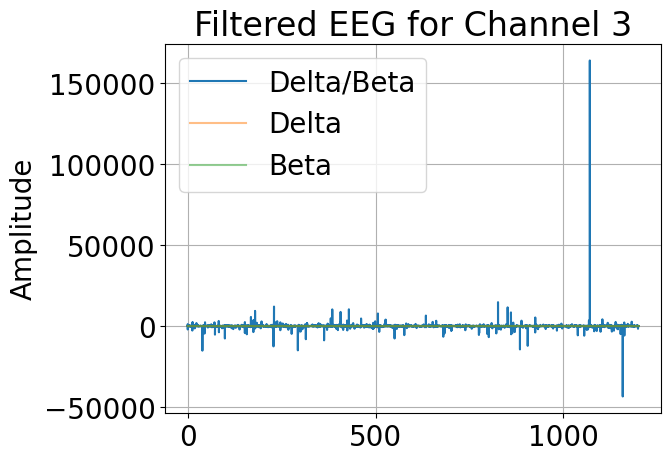

In [72]:
plot_deltaoverbeta_power(filtered_eeg_data_delta, filtered_eeg_data_beta, deltaoverbeta, sampling_rate)

extreme value affected result

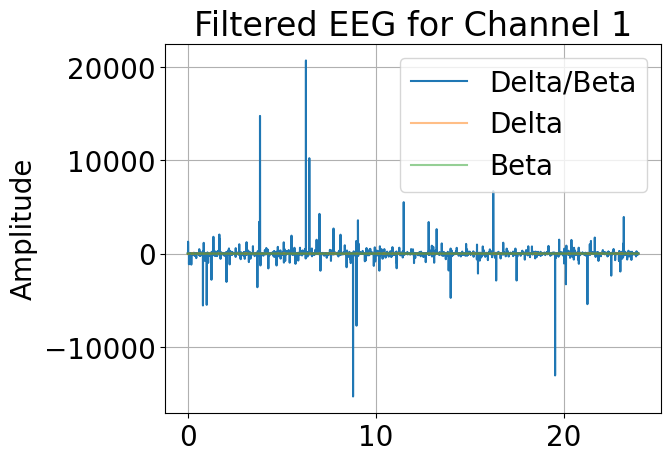

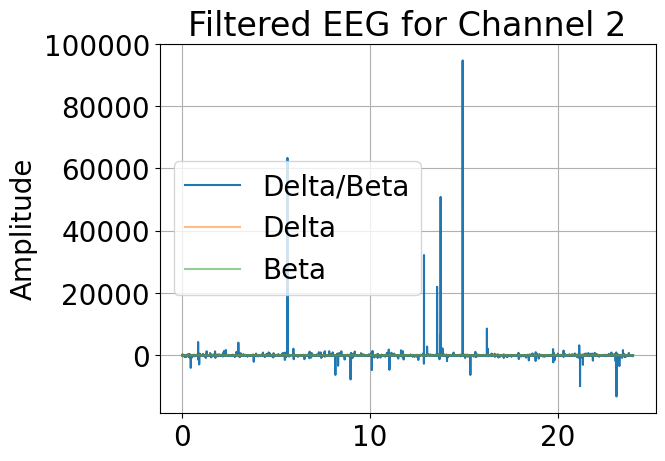

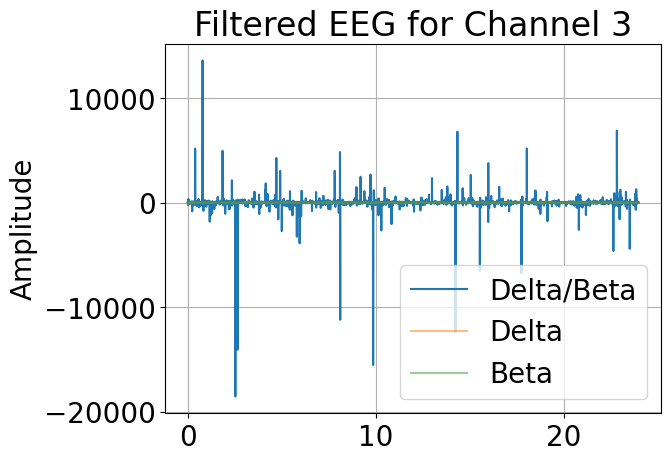

In [73]:
bin_size = int(0.2 * sampling_rate)
# Bin the data and calculate the average power within each bin
binned_power_delta = bin_data(filtered_eeg_data_delta, bin_size)
binned_power_beta = bin_data(filtered_eeg_data_beta, bin_size)

# Calculate the delta/beta ratio within each bin
delta_over_beta = binned_power_delta / binned_power_beta

plot_deltaoverbeta_power(binned_power_delta,binned_power_beta,delta_over_beta, sampling_rate)

Still not ideal, let's remove outliers

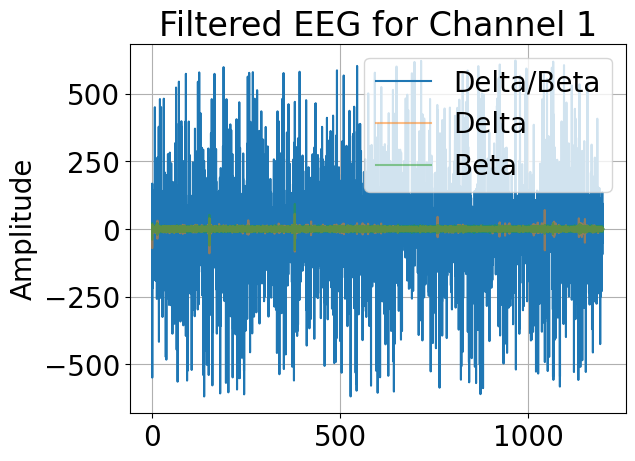

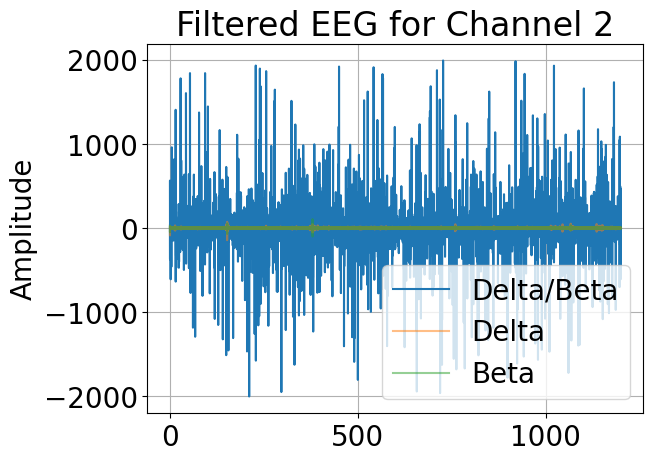

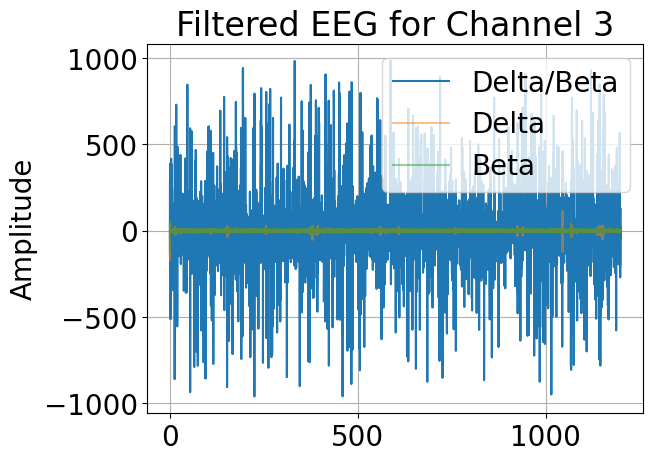

In [75]:
def remove_outliers_z_score(data, threshold=3):
    cleaned_data = np.empty(data.shape)

    for i in range(data.shape[0]):
        channel_data = data[i, :]

        # Calculate the mean and standard deviation for the channel and z-scores
        mean = np.mean(channel_data)
        std = np.std(channel_data)
        z_scores = np.abs((channel_data - mean) / std)
        # Identify the outliers
        is_outlier = z_scores > threshold

        # Replace outliers with the mean value
        cleaned_channel_data = np.where(is_outlier, mean, channel_data)

        # Store the cleaned channel data
        cleaned_data[i, :] = cleaned_channel_data

    return cleaned_data

cleaned_delta_over_beta_z = remove_outliers_z_score(deltaoverbeta)
plot_deltaoverbeta_power(filtered_eeg_data_delta, filtered_eeg_data_beta, cleaned_delta_over_beta_z, sampling_rate)